In [6]:
import numpy as np
import pickle
import h5py
from implicit.als import AlternatingLeastSquares
from scipy.sparse import csr_matrix
from sklearn.metrics import f1_score, accuracy_score

In [7]:
h5f_train = h5py.File('./Container/train', 'r')
train_features = h5f_train['features_boolean'][:]
train_labels = h5f_train['labels_int_enc'][:]
h5f_train.close()

In [8]:
h5f_valid = h5py.File('./Container/valid_cpl', 'r')
valid_features = h5f_valid['features_cpl'][:]
valid_answer = h5f_valid['features_answer'][:]
answer = np.where(valid_answer - valid_features == 1)[1]
h5f_valid.close()

In [9]:
features = np.vstack([train_features, valid_features])
features_csr = csr_matrix(features)
features_csr_T = csr_matrix(features_csr.T)

In [10]:
macro_f1_lst = []
micro_f1_lst = []
acc_lst = []
MAP_lst = []
recall10_lst = []
recall_rank_lst = []

max_dim_k = 6
for i in range(1, max_dim_k+1):
    model = AlternatingLeastSquares(factors=2**i, regularization=0.01, calculate_training_loss=True)
    model.fit(features_csr)
    recommends, scores = model.recommend([x for x in range(len(train_features), len(features))], 
                                  features_csr[len(train_features):len(features)], N=10)
    top_recommends = recommends[:,0].flatten()
    MAP = 0
    recall10 = 0
    recall_rank = 0
    recs = {}
    for query_idx in range(len(recommends)):
        recs[query_idx] = []
        for j, rec in enumerate(recommends[query_idx]):
            recs[query_idx].append((rec, scores[query_idx][j]))
            if answer[query_idx] == rec:
                MAP += 1/(j+1)
                recall10 += 1
                recall_rank += j
    MAP = MAP / len(recommends)
    recall_rank_avg = recall_rank / recall10
    recall10 = recall10/len(recommends)
    
    MAP_lst.append(MAP)
    recall10_lst.append(recall10)
    recall_rank_lst.append(recall_rank_avg)
    
    macro_f1 = f1_score(answer, top_recommends, average='macro')
    micro_f1 = f1_score(answer, top_recommends, average='micro')
    accuracy = accuracy_score(answer, top_recommends)
    macro_f1_lst.append(macro_f1)
    micro_f1_lst.append(micro_f1)
    acc_lst.append(accuracy)
    print("dim: {}\tmacro_f1: {}\tmicro_f1: {}\tacc: {}\tMAP: {}\trecall: {}\trecall_rank: {}".format(2**i, macro_f1, micro_f1, accuracy, MAP, recall10, recall_rank_avg))
    with open("./recs/CF_rec_cpl_dim_{}.pickle".format(2**i), 'wb') as f:
        pickle.dump(recs, f)

  0%|          | 0/15 [00:00<?, ?it/s]

dim: 2	macro_f1: 0.00047452208214543575	micro_f1: 0.04752803261977574	acc: 0.04752803261977574	MAP: 0.09164598603627666	recall: 0.21546890927624873	recall_rank: 3.109994086339444


  0%|          | 0/15 [00:00<?, ?it/s]

dim: 4	macro_f1: 0.0008879972277653916	micro_f1: 0.05632008154943935	acc: 0.05632008154943935	MAP: 0.09990802428684704	recall: 0.22107543323139653	recall_rank: 2.975792507204611


  0%|          | 0/15 [00:00<?, ?it/s]

dim: 8	macro_f1: 0.0012025869365134526	micro_f1: 0.05224260958205912	acc: 0.052242609582059125	MAP: 0.09593461280196768	recall: 0.22324159021406728	recall_rank: 3.2003424657534247


  0%|          | 0/15 [00:00<?, ?it/s]

dim: 16	macro_f1: 0.0014066397274081486	micro_f1: 0.047145769622833844	acc: 0.047145769622833844	MAP: 0.09096721639726242	recall: 0.22387869520897044	recall_rank: 3.3722253841775753


  0%|          | 0/15 [00:00<?, ?it/s]

dim: 32	macro_f1: 0.00273992431374931	micro_f1: 0.04268603465851172	acc: 0.04268603465851172	MAP: 0.08134323981036516	recall: 0.1954638124362895	recall_rank: 3.3168187744458932


  0%|          | 0/15 [00:00<?, ?it/s]

dim: 64	macro_f1: 0.004684806073686174	micro_f1: 0.03988277268093782	acc: 0.03988277268093782	MAP: 0.07247008640357264	recall: 0.16704892966360857	recall_rank: 3.2395118230358504


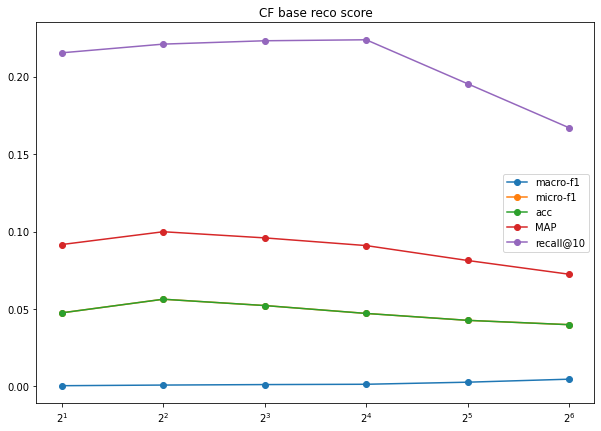

<Figure size 432x288 with 0 Axes>

In [22]:
import matplotlib.pyplot as plt

dim_lst = [2**i for i in range(1, max_dim_k+1)]

plt.figure(figsize=(10,7))
plt.plot(dim_lst, macro_f1_lst, 'o-', label='macro-f1')
plt.plot(dim_lst, micro_f1_lst, 'o-', label='micro-f1')
plt.plot(dim_lst, acc_lst, 'o-', label='acc')
plt.plot(dim_lst, MAP_lst, 'o-', label='MAP')
plt.plot(dim_lst, recall10_lst, 'o-', label='recall@10')
plt.title("CF base reco score")
plt.xscale('log', base=2)
plt.legend()
plt.show()
plt.savefig('./Data_analysis/CF_scores.png', dpi=100)

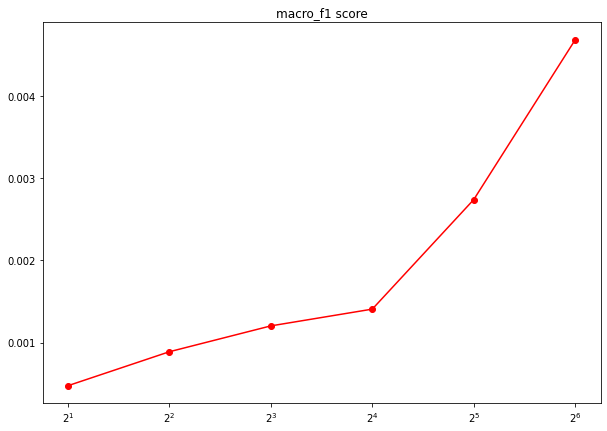

<Figure size 432x288 with 0 Axes>

In [23]:
plt.figure(figsize=(10,7))
plt.plot(dim_lst, macro_f1_lst, 'ro-')
plt.title("macro_f1 score")
plt.xscale('log', base=2)
plt.show()
plt.savefig('./Data_analysis/CF_macro_score.png', dpi=100)

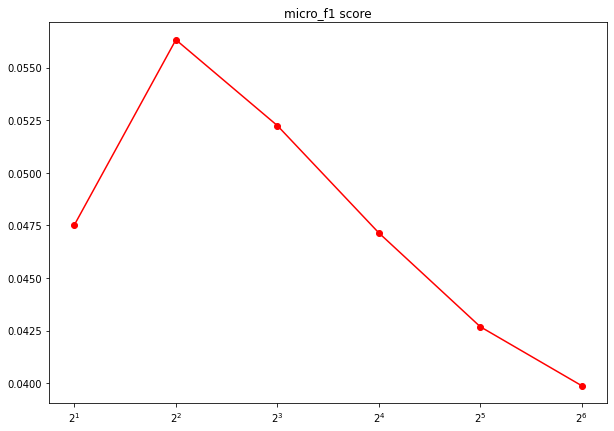

<Figure size 432x288 with 0 Axes>

In [24]:
plt.figure(figsize=(10,7))
plt.plot(dim_lst, micro_f1_lst, 'ro-')
plt.title("micro_f1 score")
plt.xscale('log', base=2)
plt.show()
plt.savefig('./Data_analysis/CF_micro_score.png', dpi=100)

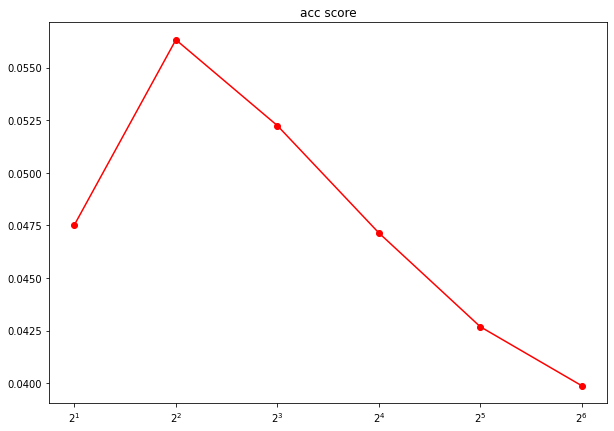

<Figure size 432x288 with 0 Axes>

In [25]:
plt.figure(figsize=(10,7))
plt.plot(dim_lst, acc_lst, 'ro-')
plt.title("acc score")
plt.xscale('log', base=2)
plt.show()
plt.savefig('./Data_analysis/CF_acc_score.png', dpi=100)

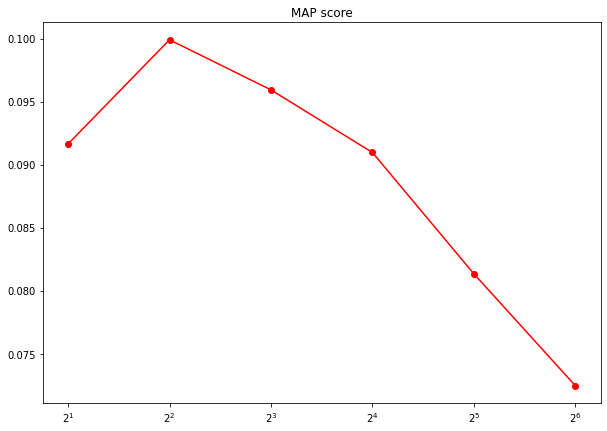

<Figure size 432x288 with 0 Axes>

In [26]:
plt.figure(figsize=(10,7))
plt.plot(dim_lst, MAP_lst, 'ro-')
plt.title("MAP score")
plt.xscale('log', base=2)
plt.show()
plt.savefig('./Data_analysis/CF_MAP_score.png', dpi=100)

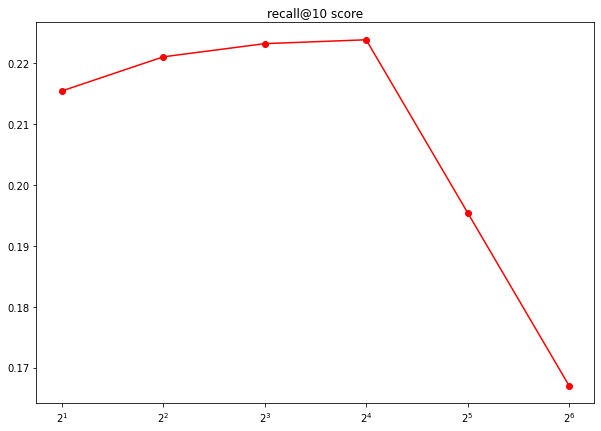

<Figure size 432x288 with 0 Axes>

In [27]:
plt.figure(figsize=(10,7))
plt.plot(dim_lst, recall10_lst, 'ro-')
plt.title("recall@10 score")
plt.xscale('log', base=2)
plt.show()
plt.savefig('./Data_analysis/CF_recall_10_score.png', dpi=100)

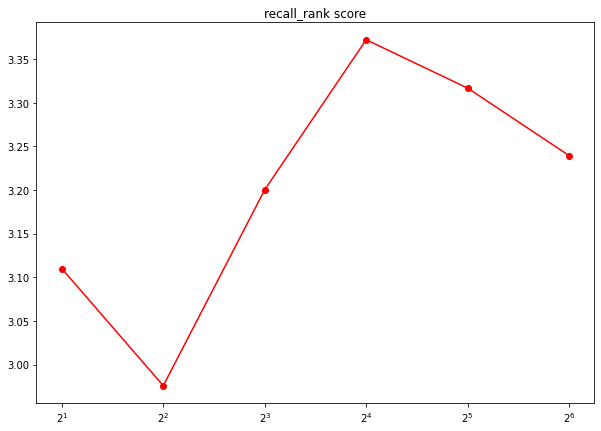

<Figure size 432x288 with 0 Axes>

In [28]:
plt.figure(figsize=(10,7))
plt.plot(dim_lst, recall_rank_lst, 'ro-')
plt.title("recall_rank score")
plt.xscale('log', base=2)
plt.show()
plt.savefig('./Data_analysis/CF_recall_rank_score.png', dpi=100)

In [29]:
recs[2]

[(908, 0.27240413),
 (4161, 0.21136163),
 (3596, 0.109503455),
 (1034, 0.09292826),
 (280, 0.09253304),
 (1045, 0.091681615),
 (2463, 0.08582595),
 (2006, 0.07959388),
 (4542, 0.0758472),
 (4348, 0.06952041)]

In [117]:
from implicit.bpr import BayesianPersonalizedRanking
macro_f1_lst = []
micro_f1_lst = []
acc_lst = []
MAP_lst = []
recall10_lst = []
for i in range(1, 11):
    model = BayesianPersonalizedRanking(factors=2**i, regularization=0.01)
    model.fit(features_csr)
    recommends, scores = model.recommend([x for x in range(len(train_features), len(features))], 
                                  features_csr[len(train_features):len(features)], N=10)
    top_recommends = recommends[:,0].flatten()
    
    MAP = 0
    recall10 = 0
    for query_idx in range(len(recommends)):
        for j, rec in enumerate(recommends[query_idx]):
            if answer[query_idx] == rec:
                MAP += 1/(j+1)
                recall10 += 1
                break
    MAP = MAP / len(recommends)
    recall10 = recall10/len(recommends)
    
    MAP_lst.append(MAP)
    recall10_lst.append(recall10)
    
    macro_f1 = f1_score(answer, top_recommends, average='macro')
    micro_f1 = f1_score(answer, top_recommends, average='micro')
    accuracy = accuracy_score(answer, top_recommends)
    macro_f1_lst.append(macro_f1)
    micro_f1_lst.append(micro_f1)
    acc_lst.append(accuracy)
    print("dim: {}\tmacro_f1: {}\tmicro_f1: {}\tacc: {}\tMAP: {}\trecall: {}".format(2**i, macro_f1, micro_f1, accuracy, MAP, recall10))

  0%|          | 0/100 [00:00<?, ?it/s]

dim: 2	macro_f1: 0.0009405010921610203	micro_f1: 0.02854230377166157	acc: 0.02854230377166157	MAP: 0.046255036163293003	recall: 0.09365443425076453


  0%|          | 0/100 [00:00<?, ?it/s]

dim: 4	macro_f1: 0.0028400335365206214	micro_f1: 0.02854230377166157	acc: 0.02854230377166157	MAP: 0.04689421427762405	recall: 0.10117227319062182


  0%|          | 0/100 [00:00<?, ?it/s]

dim: 8	macro_f1: 0.004577428524304832	micro_f1: 0.02522935779816514	acc: 0.02522935779816514	MAP: 0.04695114921605749	recall: 0.10983690112130479


  0%|          | 0/100 [00:00<?, ?it/s]

dim: 16	macro_f1: 0.005782328840630694	micro_f1: 0.022553516819571864	acc: 0.022553516819571864	MAP: 0.04541243952558933	recall: 0.11595310907237513


  0%|          | 0/100 [00:00<?, ?it/s]

dim: 32	macro_f1: 0.008331752151179915	micro_f1: 0.03147298674821611	acc: 0.03147298674821611	MAP: 0.0540535552481271	recall: 0.12066768603465851


  0%|          | 0/100 [00:00<?, ?it/s]

dim: 64	macro_f1: 0.00786768189286426	micro_f1: 0.03109072375127421	acc: 0.03109072375127421	MAP: 0.05205491642800503	recall: 0.11557084607543323


  0%|          | 0/100 [00:00<?, ?it/s]

dim: 128	macro_f1: 0.007705971374595482	micro_f1: 0.030071355759429153	acc: 0.030071355759429153	MAP: 0.051504983576848976	recall: 0.11824668705402651


  0%|          | 0/100 [00:00<?, ?it/s]

dim: 256	macro_f1: 0.005859093857500312	micro_f1: 0.03058103975535168	acc: 0.03058103975535168	MAP: 0.053701175509279456	recall: 0.11990316004077473


  0%|          | 0/100 [00:00<?, ?it/s]

dim: 512	macro_f1: 0.006294933253806808	micro_f1: 0.02841488277268094	acc: 0.02841488277268094	MAP: 0.05197542999530759	recall: 0.12117737003058104


  0%|          | 0/100 [00:00<?, ?it/s]

dim: 1024	macro_f1: 0.005642007067007356	micro_f1: 0.027905198776758414	acc: 0.02790519877675841	MAP: 0.05083440528776916	recall: 0.11709989806320081


In [118]:
from implicit.lmf import LogisticMatrixFactorization
macro_f1_lst = []
micro_f1_lst = []
acc_lst = []
MAP_lst = []
recall10_lst = []
for i in range(1, 11):
    model = LogisticMatrixFactorization(factors=2**i, regularization=0.01)
    model.fit(features_csr)
    recommends, scores = model.recommend([x for x in range(len(train_features), len(features))], 
                                  features_csr[len(train_features):len(features)], N=10)
    top_recommends = recommends[:,0].flatten()
    
    MAP = 0
    recall10 = 0
    for query_idx in range(len(recommends)):
        for j, rec in enumerate(recommends[query_idx]):
            if answer[query_idx] == rec:
                MAP += 1/(j+1)
                recall10 += 1
                break
    MAP = MAP / len(recommends)
    recall10 = recall10/len(recommends)
    
    MAP_lst.append(MAP)
    recall10_lst.append(recall10)
    
    macro_f1 = f1_score(answer, top_recommends, average='macro')
    micro_f1 = f1_score(answer, top_recommends, average='micro')
    accuracy = accuracy_score(answer, top_recommends)
    macro_f1_lst.append(macro_f1)
    micro_f1_lst.append(micro_f1)
    acc_lst.append(accuracy)
    print("dim: {}\tmacro_f1: {}\tmicro_f1: {}\tacc: {}\tMAP: {}\trecall: {}".format(2**i, macro_f1, micro_f1, accuracy, MAP, recall10))

  0%|          | 0/30 [00:00<?, ?it/s]

dim: 2	macro_f1: 0.00016759485927682558	micro_f1: 0.01643730886850153	acc: 0.01643730886850153	MAP: 0.024130351681957176	recall: 0.046890927624872576


  0%|          | 0/30 [00:00<?, ?it/s]

dim: 4	macro_f1: 0.0007753368229662079	micro_f1: 0.007517838939857288	acc: 0.007517838939857288	MAP: 0.018792928741323232	recall: 0.054408766564729864


  0%|          | 0/30 [00:00<?, ?it/s]

dim: 8	macro_f1: 0.0010473606347854523	micro_f1: 0.007900101936799185	acc: 0.007900101936799185	MAP: 0.020119219536268454	recall: 0.0609072375127421


  0%|          | 0/30 [00:00<?, ?it/s]

dim: 16	macro_f1: 0.0017355854744171555	micro_f1: 0.005733944954128441	acc: 0.005733944954128441	MAP: 0.016610338494895068	recall: 0.05007645259938838


  0%|          | 0/30 [00:00<?, ?it/s]

dim: 32	macro_f1: 0.0014424066156967928	micro_f1: 0.0031855249745158	acc: 0.0031855249745158	MAP: 0.01020323649337412	recall: 0.034658511722731905


  0%|          | 0/30 [00:00<?, ?it/s]

dim: 64	macro_f1: 0.001172443809490854	micro_f1: 0.002420998980632008	acc: 0.002420998980632008	MAP: 0.006958450641554628	recall: 0.023955147808358817


  0%|          | 0/30 [00:00<?, ?it/s]

dim: 128	macro_f1: 0.0005370898656728068	micro_f1: 0.001656472986748216	acc: 0.001656472986748216	MAP: 0.004452251508826432	recall: 0.01529051987767584


  0%|          | 0/30 [00:00<?, ?it/s]

dim: 256	macro_f1: 0.00023391329394393214	micro_f1: 0.0015290519877675841	acc: 0.0015290519877675841	MAP: 0.004007238726275423	recall: 0.013124362895005097


  0%|          | 0/30 [00:00<?, ?it/s]

dim: 512	macro_f1: 0.0	micro_f1: 0.0	acc: 0.0	MAP: 0.00012696592398427257	recall: 0.000891946992864424


  0%|          | 0/30 [00:00<?, ?it/s]

KeyboardInterrupt: 